# Двумерная аппроксимация

In [4]:

    def matrix_A(self, i, j):
        res = 0 
        x_p = i % (self.node_in_row)
        y_p = i // (self.node_in_row)
        elems = self.find_elem(x_p, y_p)
        m1 = None
        m2 = None
        
        for el in elems:
            x_f, y_f = el[0] * self.poly_deg, el[1] * self.poly_deg
            mask = ((self.x_c >= x_f) & (self.x_c <= x_f + self.poly_deg) &
                      (self.y_c >= y_f) & (self.y_c <= y_f + self.poly_deg))
            if(m1 is None):
                m1 = mask
            else:
                m1 = m1 | mask
        
        x_p = j % (self.node_in_row)
        y_p = j // (self.node_in_row)
        elems = self.find_elem(x_p, y_p)
        for el in elems:
            x_f, y_f = el[0] * self.poly_deg, el[1] * self.poly_deg
            mask = ((self.x_c >= x_f) & (self.x_c <= x_f + self.poly_deg) &
                      (self.y_c >= y_f) & (self.y_c <= y_f + self.poly_deg))
            if(m2 is None):
                m2 = mask
            else:
                m2 = m2 | mask
        
        m = m1 & m2
        for ind in m: 
            res = res + (self.phi(i,self.x[ind],self.y[ind]) *
                         self.phi(j,self.x[ind],self.y[ind]))
        return res

In [9]:
!pip install matplotlib

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import random
import pylab
import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

In [11]:
class approx_func:
    
    def __init__(self, f_point, s_point, poly_deg, element_num_row,
                 element_num_col, derivetive_type = "lagrange", integral_type = "kotice"):
        self.f_point = f_point
        self.s_point = s_point
        self.poly_deg = poly_deg
        self.element_num_row = element_num_row
        self.element_num_col = element_num_col
        self.delta_row = (s_point[0]-f_point[0])/(poly_deg * element_num_row) # Расстояние между узлами в строке
        self.delta_col = (s_point[1]-f_point[1])/(poly_deg * element_num_col)
        self.x_nodes = np.linspace(f_point[0], s_point[0], (element_num_row + 1) * poly_deg - 1)
        self.y_nodes = np.linspace(f_point[1], s_point[1], (element_num_col + 1) * poly_deg - 1) # Массив с координатами узлов
        self.num_nodes = (element_num_row * poly_deg + 1) * (element_num_col * poly_deg + 1)
        self.node_in_row = element_num_row * poly_deg + 1
        self.node_in_col = self.num_nodes // self.node_in_row
        self.x_grid, self.y_grid = np.meshgrid(self.x_nodes,self.y_nodes)
        self.derivetive_type = derivetive_type
        self.integral_type = integral_type
    
    def fit(self, x, y, z):

        self.x, self.y, self.z = np.array(x), np.array(y), np.array(z)
        self.x_c = (self.x - self.f_point[0]) / self.delta_row
        self.y_c = (self.y - self.s_point[0]) / self.delta_col
        
        start_time = time.time()
        A = np.array([self.matrix_A(i, j) if(i>=j) else 0 for i in range(self.num_nodes) 
                      for j in range(self.num_nodes)])
        A = A.reshape(self.num_nodes,-1)
        for i in range(self.num_nodes):
            for j in range(i, self.num_nodes):
                A[i,j] = A[j,i]
        self.A = A
        for i in range(len(A)):
            flag = True
            row = A[i]
            for a in row:
                if(a != 0):
                    flag = False
                    break
            if(flag):
                row[i] = 1
        #print("Time A", start_time - time.time())
        start_time = time.time()
        b = [self.vector_b(i) for i in range(self.num_nodes)]
        #print("Time b", start_time - time.time())
        self.b = b
        self.c = np.linalg.solve(A,b)
        
    def phi(self, i, x, y , dx = False, dy = False): # Функции в каждом узле
        x_p = i % (self.node_in_row)
        y_p = i // (self.node_in_row)
        x_c = (x - self.f_point[0])/self.delta_row
        y_c = (y - self.f_point[1])/self.delta_col
        elems = self.find_elem(x_p, y_p)
        el = self.check_elem(elems, x_c, y_c)

        if(el is None):
            return 0

        x_f, y_f = int(el[0] * (self.poly_deg)), int(el[1] * (self.poly_deg))
        res1,res2 = 0,0
        a = self.x_nodes[x_f:x_f+self.poly_deg + 1]
        b = self.y_nodes[y_f:y_f+self.poly_deg + 1]
        L1,L2 = 1,1
        for k in range(self.poly_deg + 1):
            if(k!=x_p - x_f):
                L1*=(x-a[k])/(a[x_p - x_f] - a[k])
            if(k!=y_p - y_f):
                L2*=(y-b[k])/(b[y_p - y_f] - b[k])

        if(dx):
            A = np.array([i for i in a if i != a[x_p - x_f]])
            B = a[x_p - x_f] - A
            return self.derivetive(x, A, B) * L2

        if(dy):
            A = np.array([i for i in b if i != b[y_p - y_f]])
            B = b[y_p - y_f] - A
            return self.derivetive(y, A, B) * L1


        return (L1*L2)
    
    def find_elem(self, x_p, y_p):
        if(x_p % self.poly_deg == 0 and x_p != 0 and x_p != self.node_in_row - 1 and
           y_p % self.poly_deg == 0 and y_p != 0 and y_p != self.node_in_col - 1):
            ind_x, ind_y = x_p / self.poly_deg - 1, y_p / self.poly_deg - 1
            res = [(ind_x, ind_y), (ind_x + 1, ind_y), (ind_x, ind_y + 1), (ind_x + 1, ind_y + 1)]
            return res

        if(x_p % self.poly_deg == 0 and x_p != 0 and x_p != self.node_in_row - 1):
            ind_x = x_p // self.poly_deg - 1
            ind_y = (y_p - 1) // self.poly_deg if y_p // self.poly_deg != 0 else 0
            res = [(ind_x, ind_y), (ind_x + 1, ind_y)]
            return res

        if(y_p % self.poly_deg == 0 and y_p != 0 and y_p != self.node_in_col - 1):
            ind_y = y_p // self.poly_deg - 1
            ind_x = (x_p - 1) // self.poly_deg if x_p // self.poly_deg != 0 else 0
            res = [(ind_x, ind_y), (ind_x, ind_y + 1)]
            return res

        ind_x = (x_p - 1) // self.poly_deg if x_p // self.poly_deg != 0 else 0
        ind_y = (y_p - 1) // self.poly_deg if y_p // self.poly_deg != 0 else 0
        return [(ind_x, ind_y)]
    
    def check_elem(self, elems, x_c, y_c):
        for el in elems:
            x_f, y_f = el[0] * self.poly_deg, el[1] * self.poly_deg
            if((x_c >= x_f and x_c <= x_f + self.poly_deg and y_c >= y_f and y_c <= y_f + self.poly_deg)):
                return el
        return 
    
    def derivetive(self, x, a, b):
    
        if len(a) == 1:
            return 1/b[0]
        else:
            L = 1
            for i in range(1, len(a)):
                L*= (x-a[i])/b[i]
            return ((x-a[0]) / b[0] * self.derivetive(x, a[1:], b[1:]) +
            1/b[0] * L)

    def matrix_A(self, i, j):
        res = 0
        for ind in range(self.x.size):
                res = res + self.phi(i,self.x[ind],self.y[ind]) * self.phi(j,self.x[ind],self.y[ind])

        return res

    def vector_b(self, i):
        res = 0
        for ind in range(self.x.size):
                res = res + (self.z[ind] * self.phi(i,self.x[ind],self.y[ind]))
        return res
    
    def app(self, x, y, dx = False, dy = False, delta = 0.01):
        res = 0
        if(self.derivetive_type == "finite" and (dx or dy)):
            if dx:
                if(x + delta > self.s_point[0]):
                    return (self.app(x, y) - self.app(x - delta, y))/(delta)
                else:
                    #print((self.app(x + delta, y) - self.app(x, y))/(delta))
                    return (self.app(x + delta, y) - self.app(x, y))/(delta)
            else: 
                if(y + delta > self.s_point[1]):
                    return (self.app(x, y) - self.app(x, y - delta))/(delta)
                else:
                    return (self.app(x, y + delta) - self.app(x, y))/(delta)
        for i in range(self.num_nodes):
            res += self.phi(i,x,y, dx, dy) * self.c[i]
        return res
    
    def print(self, n=10, dx=False, dy=False):
        
        %matplotlib qt
        fig = pylab.figure()
        axes = Axes3D(fig)
        x = np.linspace(f.f_point[0], f.s_point[0], int(f.s_point[0] - f.f_point[0]) * n)
        y = np.linspace(f.f_point[1], f.s_point[1], int(f.s_point[1] - f.f_point[1]) * n)
        x_print, y_print = np.meshgrid(x,y) 
        z_print = (np.array([self.app(x_p, y_p, dx, dy)
                      for x_p in x for y_p in y])).reshape(len(x),-1)
        axes.plot_surface(x_print, y_print, z_print, color="red" )
        pylab.show()
    
    def integral(self):
        x = np.linspace(self.f_point[0], self.s_point[0], (self.s_point[0] - self.f_point[0])*3)
        y = np.linspace(self.f_point[1], self.s_point[1], (self.s_point[1] - self.f_point[1])*3)
        res = 0
        for i in range(len(x) - 1):
            for j in range(len(y) - 1):
                del_x, del_y = x[i+1] - x[i], (y[j+1] - y[j])
                #print(x[i], x[i+1], y[j], y[j+1], f.app(x[i] + del_x/2, y[j] + del_y/2))
                res += del_x * del_y * f.app(x[i] + del_x/2, y[j] + del_y/2)
        return res
    
    def print_nodes(self):
        %matplotlib inline
        plt.plot(self.x_grid, self.y_grid, 'ro')
        plt.plot(x, y, 'ro', color = 'black', markersize = 3 )

In [12]:
def create_points(f, method='good', n=10, n_element=9):
    x, y = np.array([]), np.array([])
    if method == "good":
        a = np.linspace(f.f_point[0], f.s_point[0], f.element_num_row + 1)
        b = np.linspace(f.f_point[1], f.s_point[1], f.element_num_col + 1)
        for i in range(a.size - 1):
            for j in range(b.size - 1):
                tmp = np.random.uniform(a[i], a[i+1], n_element)
                x = np.hstack((x, tmp))
                tmp = np.random.uniform(b[j], b[j+1], n_element)
                y = np.hstack((y, tmp))
        return x, y, func(x,y) 

    elif method == "uniform":
        x = np.random.uniform(f.f_point[0], f.s_point[0], n)
        y = np.random.uniform(f.f_point[1], f.s_point[1], n)
        return x, y, func(x,y)
        
    elif method == "bad":
        x = np.random.uniform(f.f_point[0], (f.s_point[0] + f.f_point[0])/2, n)
        y = np.random.uniform(f.f_point[0], (f.s_point[0] + f.f_point[0])/2, n)
        return x, y, func(x,y)
    

In [13]:
def loss(f,metric="l2", n=3, relative=True, dx=False, dy=False):
    if(metric == "l2"):
        a = np.linspace(f.f_point[0], f.s_point[0], int(f.s_point[0] - f.f_point[0]) * n)
        b = np.linspace(f.f_point[1], f.s_point[1], int(f.s_point[1] - f.f_point[1]) * n)
        res = 0
        for i in range(a.size):
            for j in range(b.size):
                res += (func(a[i],b[j], dx, dy) - f.app(a[i], b[j], dx, dy))**2
        res = np.sqrt(res)
        if(relative):
            norm = np.sum((func(a,b, dx, dy))**2)
            return res/np.sqrt(norm)
        else:
            return res
    if(metric == "l1"):
        a = np.linspace(f.f_point[0], f.s_point[0], int(f.s_point[0] - f.f_point[0]) * n)
        b = np.linspace(f.f_point[1], f.s_point[1], int(f.s_point[1] - f.f_point[1]) * n)
        res = 0
        for i in range(a.size):
            for j in range(b.size):
                res += abs(func(a[i],b[j], dx, dy) - f.app(a[i], b[j], dx, dy))
        if(relative):
            norm = np.sum(abs(func(a,b, dx, dy)))
            return res/norm
        else:
            return res
    if(metric == "chebyshev"):
        a = np.linspace(f.f_point[0], f.s_point[0], int(f.s_point[0] - f.f_point[0]) * n)
        b = np.linspace(f.f_point[1], f.s_point[1], int(f.s_point[1] - f.f_point[1]) * n)
        m = abs(func(a[0],b[0], dx, dy) - f.app(a[0], b[0], dx, dy))
        for i in range(a.size):
            for j in range(b.size):
                tmp = abs(func(a[i],b[j], dx, dy) - f.app(a[i], b[j], dx, dy))
                if(m < tmp):
                    m = tmp
        if(relative):
            a, b = np.meshgrid(a,b)
            return m/np.max(func(a,b))
        else:
            return m

In [14]:
def print_loss(f):
    print("function metric l1: \n", loss(f, metric="l1"))
    print("function metric l2: \n", loss(f, metric="l2"))
    print("function metric chebyshev: \n",loss(f, metric="chebyshev"))
    print("dervetive dx metric l1: \n", loss(f, metric="l1", dx=True))
    print("dervetive dx metric l2: \n", loss(f, metric="l2", dx=True))
    print("dervetive dx metric chebyshev: \n", loss(f, metric="chebyshev", dx=True))
    print("dervetive dy metric l1: \n", loss(f, metric="l1", dy=True))
    print("dervetive dy metric l2: \n", loss(f, metric="l2", dy=True))
    print("dervetive dy metric chebyshev", loss(f, metric="chebyshev", dy=True))

In [15]:
def func(x, y, dx = False, dy = False):
    if(dx):
        return 1
    if(dy):
        return 1
    
    return  x**3 + y**3

In [16]:
f = approx_func(f_point=(-1, -1), s_point=(1, 1), poly_deg=3,
                element_num_row=2, element_num_col=2, derivetive_type="finite")

function metric l1: 
 4.383365606760512e-12
function metric l2: 
 2.3231555545269566e-12
function metric chebyshev: 
 1.6937562463681388e-12
dervetive dx metric l1: 
 35.16120000001194
dervetive dx metric l2: 
 7.479808042998304
dervetive dx metric chebyshev: 
 0.985050000015566
dervetive dy metric l1: 
 35.161199999942866
dervetive dy metric l2: 
 7.4798080429760825
dervetive dy metric chebyshev 0.9850500000038069


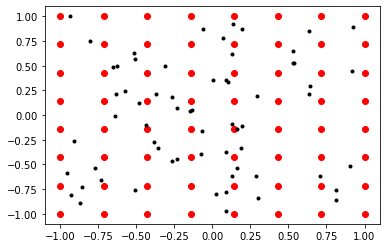

In [17]:
x, y, z = create_points(f, method='good', n_element=16)
f.fit(x, y, z)
f.print_nodes()
print_loss(f)


In [18]:
%matplotlib qt
f.print(dy=True)

In [ ]:
f.integral()

# Решение СЛАУ

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import random

In [78]:
A = np.random.randint(0,20,(5,5))
b = np.random.randint(0,20,5)

In [84]:
A

array([[19,  5, 13,  3,  8],
       [15, 12, 19,  6,  7],
       [10,  9, 19,  6, 15],
       [ 3, 12,  4,  6,  5],
       [ 8, 15,  5,  4,  1]])

In [81]:
L = np.zeros(A.shape)
U = np.zeros(A.shape)

U[0] = A[0]
L[:,0] = A[:,0]/U[0,0]

for i in range(1,A.shape[0]):
    for j in range(i, A.shape[0]):
        U[i,j] = A[i,j] - np.sum(L[i,:i] * U[:i,j])
        L[j,i] = (A[j,i] - np.sum(L[j,:i] * U[:i,i]))/U[i,i]

In [86]:
x1 = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    x1[i] = (b[i] - np.sum(A[i,:i] * x1[:i]))

In [90]:
L@x1

array([    7.        ,   -84.47368421,   684.50773994, -3527.91986321,
        2430.77332825])

In [88]:
b

array([ 7, 15, 12,  9, 13])